<a href="https://colab.research.google.com/github/samyzaf/kerutils/blob/master/chennai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment Analysis of Twitter Posts on Chennai Floods using Python**


<img src="https://samyzaf.com/ML/chennai/Chennai_1.jpg" width="75%" />


**Author: Yogesh Kulkarni**
<br/>
Source:
https://www.analyticsvidhya.com/blog/2017/01/sentiment-analysis-of-twitter-posts-on-chennai-floods-using-python
<br>
Thanks Eran Shlomo for posting it to Linkedin
<br/>
Converted and annotated to a IPython notebook: Samy Zafrany

### **Important Note!**
This notebook is currently not working due to a usage of
the outdated **GetOldTweets3** library, and due to changes and
limitations in Twitter's API or its terms of service,
which might have rendered GetOldTweets3 incompatible with the current API access requirements.

It need to be fixed by using a more up-to-date X scraping library like **snscrape** or **tweepy**, which are better maintained
and more likely to support the latest Twitter API requirements.
Special X usage privilages may also be required to scprape a
large amount of tweets.

## **Introduction**

* The best way to learn data science is to **do data science**. No second thought about it!

* One of the ways, I do this is continuously look for interesting work done by other community members. Once I understand the project, I do / improve the project on my own. Honestly, I can’t think of a better way to learn data science.

* As part of my search, I came across a study on
[sentiment analysis of Chennai Floods](https://www.analyticsvidhya.com/blog/2016/07/capstone-project/)
on Analytics Vidhya. I decided to perform sentiment analysis of the same study using Python and add it here. Well, what can be better than building onto something great.

* To get acquainted with the crisis of Chennai Floods, 2015 you can read the complete
[study](https://www.analyticsvidhya.com/blog/2016/07/capstone-project)
here. This study was done on a set of social interactions limited to the first two days of Chennai Floods in December 2015.

* The objectives of this article is to understand the different subjects of interactions during the floods using Python. Grouping similar messages together with emphasis on predominant themes (rescue, food, supplies, ambulance calls) can help government and other authorities to act in the right manner during the crisis time.

## **Building Corpus**

A typical tweet is mostly a text message within limit of 140
characters.
\#hashtags convey subject of the tweet whereas @user seeks
attention of that user.
Forwarding is denoted by ‘rt’ (retweet) and is a measure
of its popularity.
One can like a tweet by making it ‘favorite’.

About 6000 twits were collected with ‘#ChennaiFloods’ hashtag and between 1st and 2nd Dec 2015.
Jefferson’s GetOldTweets utility (got) was used in
Python 2.7 to collect the older tweets.
One can store the tweets either in a csv file or to a
database like MongoDb to be used for
further processing.

The **GetOldTweets3 (got)** Python module can be downloaded
from:
https://github.com/Jefferson-Henrique/GetOldTweets-python

Note that you will also need to download Mongo
from https://www.mongodb.com
and run a mongo server on your pc.

In [ ]:
%pip install GetOldTweets3
%pip install pymongo

In [ ]:
import GetOldTweets3 as got
from pymongo import MongoClient

In [ ]:
client = MongoClient('localhost', 27017)
db = client['twitter_db']
collection = db['twitter_collection']

def streamTweets(tweets):
   for t in tweets:
      obj = {"user": t.username, "retweets": t.retweets, "favorites":
            t.favorites, "text":t.text,"geo": t.geo,"mentions":
            t.mentions, "hashtags": t.hashtags,"id": t.id,
            "permalink": t.permalink,}
      tweetind = collection.insert_one(obj).inserted_id

In [ ]:
tweetCriteria = (
    got.manager.TweetCriteria()
               .setQuerySearch('ChennaiFloods')
               .setSince("2015-12-01")
               .setUntil("2015-12-02")
               .setMaxTweets(6000)
)

got.manager.TweetManager.getTweets(tweetCriteria, streamTweets);

Tweets stored in MongoDB can be accessed from another python script.
Following example shows how the whole db was converted to a Pandas DataFrame.

In [ ]:
import pandas as pd
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
db = client['twitter_db']
collection = db['twitter_collection']
df = pd.DataFrame(list(collection.find()))

Take a look at the 6 first records of this dataframe

In [ ]:
df.head(6)

,_id,favorites,geo,hashtags,id,mentions,permalink,retweets,text,user
0,587fd89acfc336a1dcbd23ce,10,,#ICanAccommodate #chennairains #ChennaiFloods,671775692539994115,,https://twitter.com/SirJadeja/status/671775692...,24,#ICanAccommodate #chennairains #ChennaiFloods ...,SirJadeja
1,587fd89acfc336a1dcbd23cf,7,,#ICanAccommodate #chennairains #ChennaiFloods,671776057121480706,,https://twitter.com/SirJadeja/status/671776057...,15,#ICanAccommodate #chennairains #ChennaiFloods ...,SirJadeja
2,587fd89acfc336a1dcbd23d0,16,,#ChennaiFloods,668125434760921088,,https://twitter.com/Mayankaryan084/status/6681...,49,First time in history tirupati balaji temple i...,Mayankaryan084
3,587fd89acfc336a1dcbd23d1,9,,#ICanAccommodate #chennairains #ChennaiFloods,671776149752647680,,https://twitter.com/SirJadeja/status/671776149...,28,#ICanAccommodate #chennairains #ChennaiFloods ...,SirJadeja
4,587fd89acfc336a1dcbd23d2,0,,#ChennaiFloods,671841135778598914,,https://twitter.com/deeepakkher/status/6718411...,0,#ChennaiFloods havoc caused by incessant rains...,deeepakkher
5,587fd89acfc336a1dcbd23d3,0,,#ChennaiFloods #chennairainshelp #chennairains,671841120574312448,,https://twitter.com/sreeni94/status/6718411205...,9,Blankets....Bread.. Biscuits PL Share #Chennai...,sreeni94


# **Data Exploration**

Once in dataframe format, it is easier to explore the data. Here are few examples:

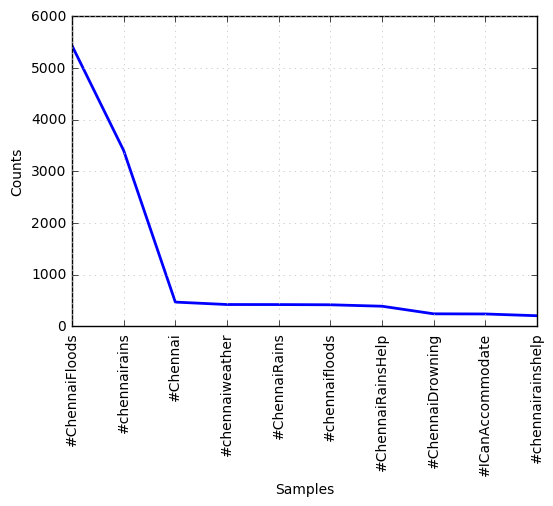

In [ ]:
# FreqDist = Frequency Distribution of words list
from nltk import FreqDist
hashtags = []
for hs in df["hashtags"]: # Each entry may contain multiple hashtags. We need to split.
       hashtags += hs.split(" ")
hashtag_dist = FreqDist(hashtags)
hashtag_dist.plot(10)

As seen in the
[study](https://www.analyticsvidhya.com/blog/2016/07/capstone-project)
the most used tags were “#chennairains”, “#ICanAccommodate”, apart from the original query tag “#ChennaiFloods”.

## **Top 10 users**

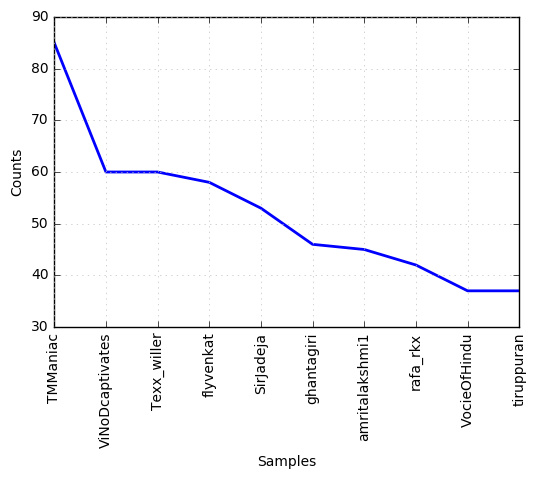

In [ ]:
users = df["user"].tolist()
users_dist = FreqDist(users)
users_dist.plot(10)

# **Text Pre-processing**

All tweets are processed to remove unnecessary things like links, non-English words, stopwords, punctuation’s, etc. We employ the power of the **nltk.tokenize** and **nltk.corpus** modules:

In [ ]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import re, string
import nltk
tweets_texts = df["text"].tolist()
stopwords = stopwords.words('english')
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

In [ ]:
def process_tweet_text(tweet):
   if tweet.startswith('@null'):
       return "[Tweet not available]"
   tweet = re.sub(r'\$\w*','',tweet) # Remove tickers
   tweet = re.sub(r'https?:\/\/.*\/\w*','',tweet) # Remove hyperlinks
   tweet = re.sub(r'['+string.punctuation+']+', ' ',tweet) # Remove puncutations like 's
   twtok = TweetTokenizer(strip_handles=True, reduce_len=True)
   tokens = twtok.tokenize(tweet)
   tokens = [i.lower() for i in tokens if i not in stopwords and len(i) > 2 and
                                             i in english_vocab]
   return tokens

In [ ]:
words = []
for tw in tweets_texts:
    words += process_tweet_text(tw)

In [ ]:
# How many words do we have?
len(words)

17702

In [ ]:
# Take a look at the first 15 words
words[0:15]

[u'time',
 u'history',
 u'temple',
 u'closed',
 u'due',
 u'pic',
 u'twitter',
 u'havoc',
 u'incessant',
 u'flooding',
 u'result',
 u'cause',
 u'misery',
 u'city',
 u'pic']

# **Text Exploration**

The words are plotted again to find the most frequently used terms. A few simple words repeat more often than others: ’help’, ‘people’, ‘stay’, ’safe’, etc.

[(‘twitter’, 1026), (‘pic’, 1005), (‘help’, 569), (‘people’, 429), (‘safe’, 274)]

These are immediate reactions and responses to the crisis.

Some infrequent terms are [(‘fit’, 1), (‘bible’, 1), (‘disappear’, 1), (‘regulated’, 1), (‘doom’, 1)].

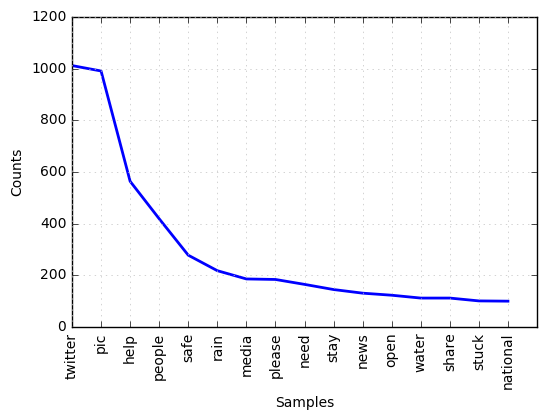

In [ ]:
words_dist = FreqDist(words)
words_dist.plot(16)

Collocations are the words that are found together. They can be bi-grams (two words together) or phrases like trigrams (3 words) or n-grams (n words).

In [ ]:
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(words, 5)
finder.apply_freq_filter(5)
for word1,word2 in finder.nbest(bigram_measures.likelihood_ratio, 10):
    print(word1, word2)

pic twitter
lady labour
national media
pani pani
team along
beyond along
rescue team
stay safe
team beyond
rescue along


These depict the disastrous situation, like “stay safe”, “rescue team”, even a commonly used Hindi phrase “pani pani” (lots of water).

# **Clustering**

In such crisis situations, lots of similar tweets are generated. They can be grouped together in clusters based on closeness or ‘distance’ amongst them. Artem Lukanin has explained the process in details here. TF-IDF method is used to vectorize the tweets and then cosine distance is measured to assess the similarity.

Each tweet is pre-processed and added to a list. The list is fed to TFIDF Vectorizer to convert each tweet into a vector. Each value in the vector depends on how many times a word or a term appears in the tweet (TF) and on how rare it is amongst all tweets/documents (IDF). Below is a visual representation of TFIDF matrix it generates.

In [ ]:
cleaned_tweets = []
for tw in tweets_texts:
    words = process_tweet_text(tw)
    #Form sentences of processed words
    cleaned_tweet = " ".join(w for w in words if len(w) > 2 and w.isalpha())
    cleaned_tweets.append(cleaned_tweet)
df['CleanTweetText'] = cleaned_tweets

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,3))
tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_tweets)
feature_names = tfidf_vectorizer.get_feature_names() # num phrases
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
print(dist)

[[  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   1.00000000e+00
    1.00000000e+00   1.00000000e+00]
 [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   1.00000000e+00
    1.00000000e+00   1.00000000e+00]
 [  1.00000000e+00   1.00000000e+00   0.00000000e+00 ...,   1.00000000e+00
    1.00000000e+00   9.64312734e-01]
 ..., 
 [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   0.00000000e+00
    1.00000000e+00   1.00000000e+00]
 [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   1.00000000e+00
   -2.22044605e-16   1.00000000e+00]
 [  1.00000000e+00   1.00000000e+00   9.64312734e-01 ...,   1.00000000e+00
    1.00000000e+00  -2.22044605e-16]]


In [ ]:
from sklearn.cluster import KMeans
num_clusters = 3
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()
df['ClusterID'] = clusters
print(df['ClusterID'].value_counts())

0    5498
2     426
1      76
Name: ClusterID, dtype: int64


We obtained 3 clusers:
1. Clustr 0 with 5498 tweets
2. Cluster 1 with 76 tweets
3. Cluster 2 with 426 tweets

The top words used in each cluster can be computed by as follows:

In [ ]:
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster {}: Words:".format(i))
    for ind in order_centroids[i, :10]:
        print('    %s' % feature_names[ind])

Cluster 0 : Words :
    help
    people
    twitter
    pic
    pic twitter
    safe
    open
    rain
    share
    please
Cluster 1 : Words :
    situation
    people
    situation better
    better
    people situation
    situation pic twitter
    situation pic
    better soon
    soon
    bad
Cluster 2 : Words :
    pic
    pic twitter
    twitter
    guess pic twitter
    gud make sure
    gud work
    guess
    guess medical
    guess medical aid
    guess pic


The result is:

* Cluster 0: Words: show mercy please people rain
* Cluster 1: Words: pic twitter zoo wall broke ground saving guilty water growing
* Cluster 2: Words: help people pic twitter safe open rain share please

# **Doc2Vec and K-means**

Doc2Vec methodology available in gensim package is used to vectorize the tweets,
as follows:

In [ ]:
import gensim
from gensim.models.doc2vec import TaggedDocument
taggeddocs = []
tag2tweetmap = {}
for index,i in enumerate(cleaned_tweets):
    if len(i) > 2: # Non empty tweets
        tag = u'SENT_{:d}'.format(index)
        sentence = TaggedDocument(words=gensim.utils.to_unicode(i).split(), tags=[tag])
        tag2tweetmap[tag] = i
        taggeddocs.append(sentence)
model = gensim.models.Doc2Vec(taggeddocs, dm=0, alpha=0.025, size=20, min_alpha=0.025, min_count=0)
for epoch in range(60):
    if epoch % 20 == 0:
        print('Training epoch: %s' % epoch)
    model.train(taggeddocs)
    model.alpha -= 0.002  # decrease the learning rate
    model.min_alpha = model.alpha  # fix the learning rate, no decay

c:\anaconda2\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Now training epoch 0
Now training epoch 20
Now training epoch 40


Once trained model is ready the tweet-vectors available in model can be clustered using K-means.

In [ ]:
from sklearn.cluster import KMeans
dataSet = model.syn0
kmeansClustering = KMeans(n_clusters=6)
centroidIndx = kmeansClustering.fit_predict(dataSet)
topic2wordsmap = {}
for i,val in enumerate(dataSet):
    tag = model.docvecs.index_to_doctag(i)
    topic = centroidIndx[i]
    if topic in topic2wordsmap.keys():
        for w in (tag2tweetmap[tag].split()):
            topic2wordsmap[topic].append(w)
    else:
        topic2wordsmap[topic] = []
for i in topic2wordsmap:
    words = topic2wordsmap[i]
    print("Topic {} has words {}".format(i, words[:5]))

Topic 0 has words [u'rescue', u'team', u'area', u'beyond', u'along']
Topic 1 has words [u'amid', u'heavy', u'rain', u'airport', u'shut']
Topic 2 has words [u'everyone', u'safe', u'away', u'boat', u'boat']
Topic 3 has words [u'situation', u'total', u'ongoing', u'pic', u'twitter']
Topic 4 has words [u'corrupt', u'lightening', u'speed', u'midst', u'climate']
Topic 5 has words [u'resume', u'airport', u'stuck', u'terminal', u'goi']


In [ ]:
dataSet.shape

(2359L, 20L)

# **End Notes**

This article shows how to implement Capstone-Chennai Floods study using Python and its libraries.
With this tutorial, one can get introduction to various Natural Language Processing (NLP)
workflows such as accessing twitter data, pre-processing text, explorations, clustering
and topic modeling.